In [74]:
#WORDS_FILE = 'names.txt'
WORDS_FILE = 'swears.txt'
#WORDS_FILE = 'towns.txt'
#WORDS_FILE = 'cities.txt'

In [75]:
words = open(WORDS_FILE, 'r', encoding="utf8").read().splitlines()
words = [w.lower() for w in words]
words = [w for w in words if (len(w) > 0)]
words[:10]

['анус',
 'аборт',
 'бздун',
 'беспезды',
 'бздюх',
 'бля',
 'блудилище',
 'блядво',
 'блядеха',
 'блядина']

In [76]:
len(words)

1317

In [77]:
min(len(n) for n in words)

3

In [78]:
max(len(n) for n in words)

18

In [79]:
min(words, key=len)

'бля'

In [80]:
max(words, key=len)

'пропиздоболиваться'

In [81]:
bigrams = {}
for w in words:
    chs = '.' + w + '.'    
    for a, b in zip(chs, chs[1:]):
        bigram = (a, b)
        bigrams[bigram] = bigrams.get(bigram, 0) + 1
#sorted(bigrams.items(), key = lambda kv: -kv[1])

In [82]:
letters = sorted(list(set(''.join(words))))
chtoi = {ch:(i+1) for i,ch in enumerate(letters)}
chtoi['.'] = 0
N = len(letters) + 1

In [83]:
import torch

hist = torch.zeros(N, N, dtype = torch.int32)
for bg in bigrams.items():
    a = chtoi[bg[0][0]]
    b = chtoi[bg[0][1]]
    hist[a,b] = bg[1]
P = (hist+1).float()
P /= P.sum(dim=1, keepdim=True)

(-0.5, 35.5, 35.5, -0.5)

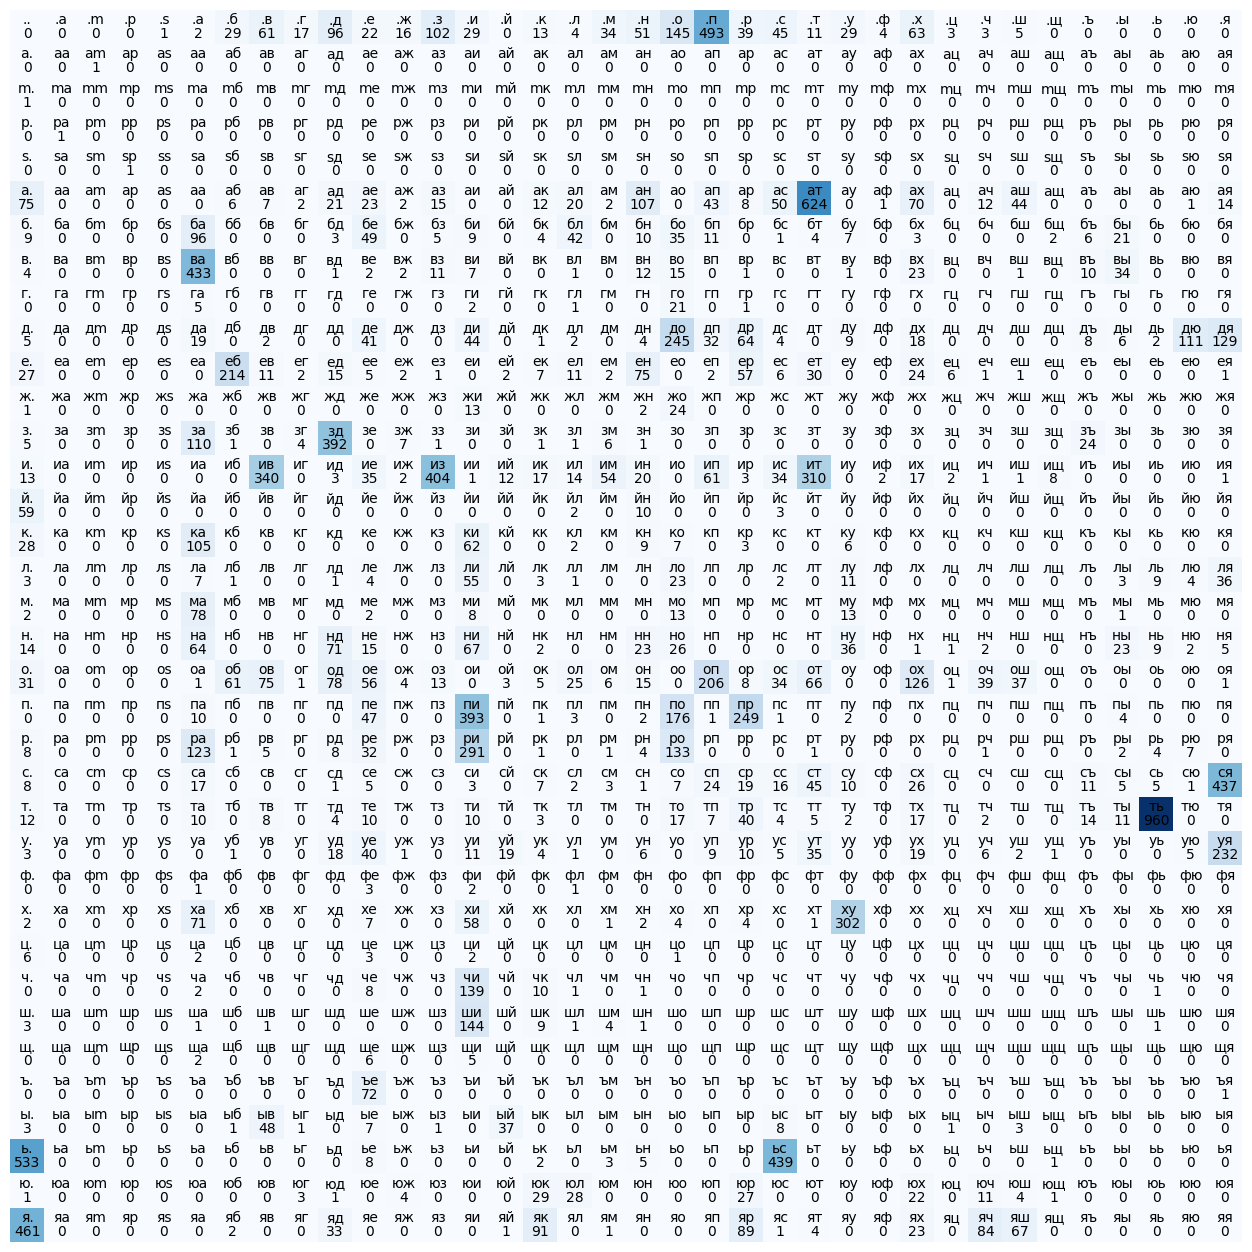

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline
itoch = {i:ch for ch,i in chtoi.items()}
plt.figure(figsize=(16,16))
plt.imshow(hist, cmap='Blues')
for i in range(N):
    for j in range(N):
        chstr = itoch[i] + itoch[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='black')
        plt.text(j, i, hist[i, j].item(), ha='center', va='top', color='black')
plt.axis('off')

In [85]:
g = torch.Generator().manual_seed(2147483647)
def get_word(g):
    idx = 0
    word = ''
    while True:
        idx = torch.multinomial(P[idx], num_samples=1, replacement=True, generator=g).item()
        if idx == 0:
            break
        word += itoch[idx]
    return word
for i in range(30):
    print(get_word(g))

здоеsся
поподхуя
здякцать
питриндпиздиваться
подюхуяраться
сячебеmsшиздхуя
здочебеблфся
пиздосярипопбкаприенуя
похуерать
м
пивать
някизаначиздеться
дроеть
дюля
поошгоебебобохуячsванохупизадюхуя
пиздюроль
н
онизд
добаться
пизяритивасяшиздочизать
ваныебыгрануяшиздопрахахуя
дрдохиздлкашипгатьсякатьс
пь
опитьсяшиздпиприть
пася
дюроть
жбеный
мандуя
похуя
пивывак


In [86]:
likelyhood = 1
log_likelyhood = 0
avg_neg_log_likelyhood = 0

hist = torch.zeros(N, N, dtype = torch.int32)
for w in words:
    chs = '.' + w + '.'    
    for a, b in zip(chs, chs[1:]):
        i = chtoi[a]
        j = chtoi[b]
        prob = P[i, j]
        likelyhood *= prob
        log_likelyhood += torch.log(prob)
        avg_neg_log_likelyhood += 1
neg_log_likelyhood = -log_likelyhood
avg_neg_log_likelyhood = neg_log_likelyhood / avg_neg_log_likelyhood

print(f'{likelyhood=}, {log_likelyhood=}, {neg_log_likelyhood=}, {avg_neg_log_likelyhood=}')

likelyhood=tensor(0.), log_likelyhood=tensor(-24797.8027), neg_log_likelyhood=tensor(24797.8027), avg_neg_log_likelyhood=tensor(1.6408)


In [93]:
import torch.nn.functional as F
xs, ys = [], []
for w in words:
    chs = '.' + w + '.'    
    for a, b in zip(chs, chs[1:]):
        i = chtoi[a]
        j = chtoi[b]
        xs.append(i)
        ys.append(j)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
xs_oh = F.one_hot(xs, num_classes=N).float()
ys_oh = F.one_hot(ys, num_classes=N).float()
ys_oh.shape


torch.Size([15113, 36])

In [94]:
W = torch.randn((N, N), generator=g, requires_grad = True)
for k in range(200):
    logits = xs_oh @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(len(xs)), ys].log().mean()
    W.grad = None
    loss.backward()
    W.data -= 50 * W.grad
    if k % 10 == 0:
        print(loss.item())
        

3.988131046295166
1.9421160221099854
1.7893900871276855
1.7300564050674438
1.7004234790802002
1.6821616888046265
1.669611930847168
1.660400390625
1.6533024311065674
1.6476457118988037
1.6430344581604004
1.6392128467559814
1.6360023021697998
1.6332719326019287
1.6309236288070679
1.6288821697235107
1.6270908117294312
1.625504732131958
1.6240897178649902
1.6228184700012207


In [95]:
g = torch.Generator().manual_seed(2147483647)
idx = 0
for k in range(20):
    word = ''
    while True:
        oh = F.one_hot(torch.tensor([idx]), num_classes=N).float()
        logits = oh @ W
        counts = logits.exp()
        res = counts / counts.sum(1, keepdim=True)
        idx = torch.multinomial(res, num_samples=1, replacement=True, generator=g).item()
        if idx == 0:
            print(word)
            break
        word += itoch[idx]

здоенивать
махуя
здякиздя
питриндпиздоваться
подюхуяраться
сячебеmsй
здхуя
здочебеблиздюлывать
рипопризашиенуя
похуерать
мандое
фъехуя
прачиздеться
дроеть
дюля
поошиватьскизать
sванохуяшиватривать
здохипиватъенд
добаться
пизяритьсяриваться
